In [5]:
import quandl, math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
# 用label代表字段：预测结果
# 通过让 Adj. Close 列的数据往前移动1%行来表示
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
# 生成label列时留下的最后1%行的数据，这些行并没有label数据，因此我们可以拿他们作为预测时用到的输入数据
# X_lately变量包含最近的特征
X_lately = X[-forecast_out:]
# 取数据的前99%
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)
forecast_set= clf.predict(X_lately)
print(forecast_set)
style.use('ggplot')
# 新加预测列
df['Forecast'] = np.nan
# 取最后一行的时间索引 iloc函数 
# 基于索引位来选取数据集，0:4就是选取 0，1，2，3这四行，需要注意的是这里是前闭后开集合
# https://blog.csdn.net/weixin_39501270/article/details/76833836
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

0.977788397318
[ 1098.8676096   1071.20847161  1016.8077294   1056.73145312  1072.20918028
  1072.94781482  1090.50882394  1109.08507361  1114.26666663  1121.61393655
  1131.38451564  1128.36163541  1147.09977798  1163.46002696  1134.73735971
  1121.36413325  1085.76935731  1100.8030371   1112.5658155   1120.52815709
  1133.43568993  1149.07614904  1179.48813135  1185.07208742  1155.52183131
  1168.10203122  1168.89231604  1151.98996208  1116.63298379  1113.53897857
  1112.19171632  1068.43834048  1040.9031372   1068.30742995  1017.14663092]


In [7]:
for i in forecast_set:
    # 时间戳转换为日期类型
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    # [np.nan for _ in range(len(df.columns) - 1)]生成不包含Forecast字段的列表
    # 而[i]是只包含Forecast值的列表
    # 上述两个列表拼接在一起就组成了新行，按日期追加到df的下面
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]  

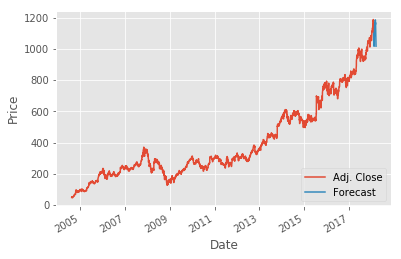

In [8]:
# 开始绘图
df['Adj. Close'].plot()
df['Forecast'].plot()
# 显示图例 https://blog.csdn.net/you_are_my_dream/article/details/53440964
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

完成了训练，测试，预测保存参数模块，参考regression_pickle